<u>An initial model:</u>

<u>Environment:</u>

A two-dimensional domain, divided up into a grid of square cells.

<u>Agents:</u>

The cells themselves, which can be (i) flammable; (ii) growing; (iii) burnt; (iv) burning.

<u>Algorithm:</u>

The motivation for the model is that fire spreads to neighbouring areas. After trees have burnt they take
some time to regrow and become flammable again.

For an arbitrary state, one update of the system consists of the following steps, performed in parallel for all
cells:

1. Spread fire: a flammable cell with at least one burning neighbour becomes burning (otherwise it
remains flammable).
2. Burning: a burning cell becomes burnt.
3. Germination: a burnt cell becomes growing.
4. Grow: a growing cell becomes flammable.


In [779]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib.colors import ListedColormap

In [780]:
global cell_type_dict 
cell_type_dict = {"EucalyptOF":[0.8, 85], "EucalyptW":[0.9, 85], "Other":[1, 90], "Clear":[0, 0]} # [Veg_dampening, No_fire_moist_threshold]

In [781]:
class Cell:

    def __init__(self, state, wind, fire_exposure, moisture, revive_counter, growth_counter, prob_burn, veg_type, color):
        self.state = state
        self.wind = wind
        self.fire_exposure = fire_exposure
        self.moisture = moisture
        self.revive_counter = revive_counter
        self.growth_counter = growth_counter
        self.prob_burn = prob_burn
        self.veg_type = veg_type
        self.color = color

    def get_State(self):
        return self.state
    
    def get_Wind(self):
        return self.wind
    
    def get_FireExposure(self):
        return self.fire_exposure
    
    def get_Moisture(self):
        return self.moisture
    
    def get_ReviveCounter(self):
        return self.revive_counter
    
    def get_GrowthCounter(self):
        return self.growth_counter
    
    def get_ProbBurn(self):
        return self.prob_burn
    
    def get_VegType(self):
        return self.veg_type
    
    def get_Color(self):
        return self.color
    
    def set_State(self, state):
        self.state = state
    
    def set_Wind(self, wind):
        self.wind = wind

    def set_FireExposure(self, fire_exposure):
        self.fire_exposure = fire_exposure
    
    def set_Moisture(self, moisture):
        self.moisture = moisture
    
    def set_ReviveCounter(self, rc):
        self.revive_counter = rc
    
    def set_GrowthCounter(self, gc):
        self.growth_counter = gc
    
    def reset_ReviveCounter(self):
        self.revive_counter = 0

    def reset_GrowthCounter(self):
        self.growth_counter = 0
    
    def calc_ProbBurn(self):
        exp_for_1 = 3 # Ammount of fire exposure for 100% of cathing fire with 0% moisture
        veg_type_dampening = cell_type_dict[self.veg_type][0] 
        moisture_thresh = cell_type_dict[self.veg_type][1] # % of moisture for not flammable of veg_type
        self.prob_burn = 1 * veg_type_dampening * self.fire_exposure/exp_for_1 * min(int(self.moisture<moisture_thresh), (1 - self.moisture/100))

    def set_VegType(self, veg_type):
        self.veg_type = veg_type

    def set_Color(self, color):
        self.color = color


In [782]:
def new_forest(forest_size):
    '''
    Set up a new, forest
    forest_size = [n,m]
    '''
    n, m = forest_size
    forest = np.empty((n, m), dtype=object)
    for i in range(forest.shape[0]):
        for j in range(forest.shape[1]):
            if i == 0 or j == 0 or i == n-1 or j == m-1:
                forest[i, j] = Cell(4, [0, 0], 0, 0, 0, 0, 1, "Other", 0) 
            else:
                forest[i, j] = Cell(0, [0, 0], 0, 0, 0, 0, 1, "Other", 0)

    return forest # start all cells as flammable (represents a grown standard forest)

def import_forest(in_forest):
    # 0 -- Not in the area
    # 3 -- Eucalypt Open Forests
    # 5 -- Eucalypt Woodlands
    # 10 -- Other Forest and Woodland
    # 25 -- Cleared, non-native vegetation, buildings
    map = {0:"Clear", 3:"EucalyptOF", 5:"EucalyptW", 10:"Other", 25:"Clear"}
    n, m = in_forest.shape[0], in_forest.shape[1]
    forest = np.empty((n, m), dtype=object)
    for i in range(forest.shape[0]):
        for j in range(forest.shape[1]):
            if in_forest[i, j] != 0:
                forest[i, j] = Cell(0, [0, 0], 0, 0, 0, 0, 1, map[in_forest[i, j]], 0)
            else:
                # print("a")
                forest[i, j] = Cell(4, [0, 0], 0, 0, 0, 0, 1, map[in_forest[i, j]], 0)
    return forest

In [783]:
def random_forest_fire(forest_size, p):
    '''
    Set up a random forest where a cell is burning with probability p
    '''
    n, m = forest_size
    forest = new_forest(forest_size)
    set_fire = np.random.rand(n, m) < p
    for i in range(n):
        for j in range(m):
            if set_fire[i, j]:
                forest[i][j].set_State(3)
    return forest

def random_forest_fire_import(forest, p):
    '''
    Set up a random forest where a cell is burning with probability p
    '''
    forest = import_forest(forest)
    set_fire = np.random.rand(forest.shape[0], forest.shape[1]) < p
    for i in range(forest.shape[0]):
        for j in range(forest.shape[1]):
            if set_fire[i, j] and forest[i][j].get_State() != 4 and forest[i][j].get_VegType() != "Clear":
                forest[i][j].set_State(3)
    return forest


def localized_forest_fire(forest_size, row, col, size=(1,1)):
    '''
    Set up a forest where a cell or multiple (depending on size) at (row, col) is burning
    '''
    forest = new_forest(forest_size)

    for x_offset in range(size[0]):
        for y_offset in range(size[1]):
            forest[row+x_offset, col+y_offset].set_State(3) # Set some cells to the Burning state (forest fires starting coordinates)
    return forest

def localized_forest_fire_import(forest, row, col, size=(1,1)):
    '''
    Set up a forest where a cell or multiple (depending on size) at (row, col) is burning
    '''
    forest = import_forest(forest)

    for x_offset in range(size[0]):
        for y_offset in range(size[1]):
            forest[row+x_offset, col+y_offset].set_State(3) # Set some cells to the Burning state (forest fires starting coordinates)
    return forest

In [784]:
def plot_board(forest, ax=None):
    ''' 
    Plot a board with blue (4) = empty, green (0) = flammable, gold (1) = growing, black (2) = burnt, dark_orange (3) = burning
    '''
    # Because of how the imshow function works, we need to define a new color mapping taaking into account the values for veg_type
    cmap = ListedColormap([
            "#58b6ed", # 0 -- Not in the area
            "gold", # 1 -- growing
            "#1a1a1a", # 2 -- burnt
            "darkorange", # 3 -- burning
            "#0d470f", # 4 -- Eucalypt Open Forests
            "#1d9612", # 5 -- Eucalypt Woodlands
            "#a5f0a8", # 6 -- Other Forest and Woodland
            "#b6b8b6", # 7 -- Cleared, non-native vegetation, buildings
        ])
    
    for i in range(forest.shape[0]):
        for j in range(forest.shape[1]):
            # First handle all non flammable states
            state = forest[i, j].get_State()
            if state == 4:
                forest[i, j].set_Color(0)
            elif state == 1:
                forest[i, j].set_Color(1)
            elif state == 2:
                forest[i, j].set_Color(2)
            elif state == 3:
                forest[i, j].set_Color(3)
            elif state == 0: # Cell is in the flammable state, so color depends on veg_type
                # "EucalyptOF", "EucalyptW", "Other", "Clear"
                veg_type = forest[i, j].get_VegType()
                if veg_type == "EucalyptOF":
                    forest[i, j].set_Color(4)
                elif veg_type == "EucalyptW":
                    forest[i, j].set_Color(5)
                elif veg_type == "Other":
                    forest[i, j].set_Color(6)
                elif veg_type == "Clear":
                    forest[i, j].set_Color(7)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6), dpi=200)
    ax.imshow([[cell.get_Color() for cell in row] for row in forest], cmap=cmap, origin="lower", vmin=0, vmax=7)
    return ax

In [785]:
def get_cell(forest, row, col):
    '''
    Return the value of the cell at (row,col) in board, 
    modulo the size of the board
    '''
    return forest[row, col]

In [786]:
def set_cell(forest, row, col, value):
    '''
    Assign the given value to the cell at (row,col) in board, 
    modulo the size of the board
    '''
    forest[row, col].set_State(value)
    return forest

In [787]:
def count_neighbours(forest, row, col):
    '''
    Count the number of neighbours cells with each state of cell at (row,col), 
    with periodic boundary conditions (implemented through get_cell)
    '''
    result = {0:0, 1:0, 2:0, 3:0, 4:0}
    for i in range(row-1, row+2):
        for j in range(col-1, col+2):
            if not (i == row and j == col) and 0 <= i < forest.shape[0] and 0 <= j < forest.shape[1]:
                result[get_cell(forest, i, j).get_State()] += 1

    return result

# Wind

In [788]:
def constant_wind(forest, x_component, y_component):
    '''
    Set up a constant wind across all the forest given the x-component and the y-component
    '''
    for i in range(forest.shape[0]):
        for j in range(forest.shape[1]):
            forest[i][j].set_Wind([x_component, y_component])
    return forest

def vortex_wind(forest, cx, cy, strength=1.0):
    """
    Assigns a counter-clockwise vortex wind around center (cx, cy).
    strength controls magnitude.
    """
    n_rows, n_cols = forest.shape

    for i in range(n_rows):
        for j in range(n_cols):
            dx = j - cx        # x distance from center
            dy = i - cy        # y distance from center

            # perpendicular vector for CCW rotation: (-dy, dx)
            wx = -dy * strength
            wy =  dx * strength

            forest[i][j].set_Wind([wx, wy])

    return forest

## Visualising wind field

In [789]:
import numpy as np
import matplotlib.pyplot as plt

def plot_board_wind(forest):

    n_rows, n_cols = forest.shape
    # Create coordinate grid
    X, Y = np.meshgrid(np.arange(n_cols), np.arange(n_rows))

    # Get wind components
    U = np.zeros((n_rows, n_cols))
    V = np.zeros((n_rows, n_cols))
    for i in range(n_rows):
        for j in range(n_cols):
            x, y = forest[i][j].get_Wind()
            U[i, j] = x
            V[i, j] = y

    # Combined wind strength
    mag = np.sqrt(U**2 + V**2)

    # Quiver plot
    fig, ax = plt.subplots(figsize=(6, 6), dpi=200)
    q = ax.quiver(
        X, Y, U, V, mag,
        cmap="Blues", scale_units="xy", scale=1, width=0.005 , pivot='tail'
    )

    ax.set_aspect('equal')

    # Wind strength
    cbar = plt.colorbar(q, ax=ax)
    cbar.set_label("Wind Speed (combined)")

    ax.set_title("Wind Vector Field")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    plt.show()


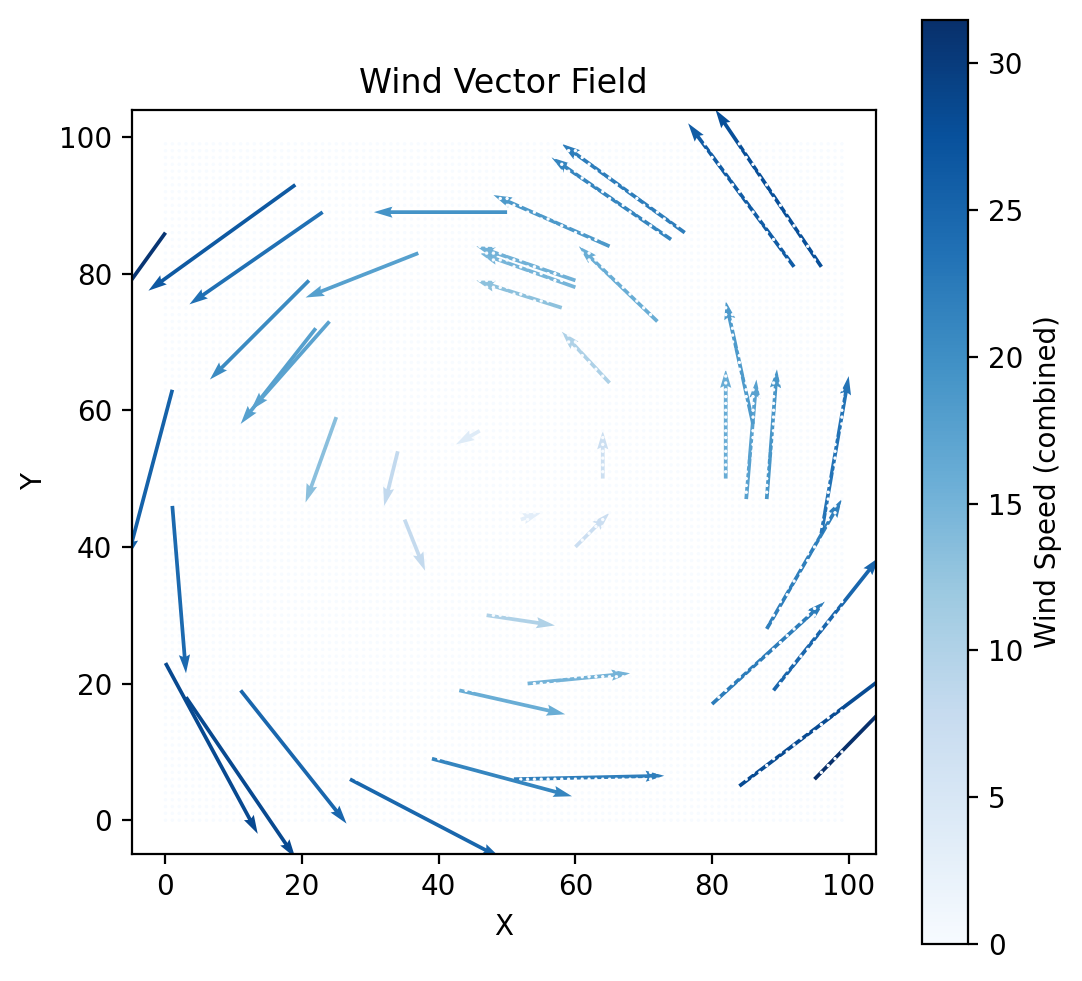

In [790]:
forest = random_forest_fire([100, 100], 0.005)
# forest = localized_forest_fire([100, 100], 25, 25, (1,1))


# constant_wind(forest, 10, 5)
vortex_wind(forest, cx=50, cy=50, strength=0.5)

for i in range(forest.shape[0]):
    for j in range(forest.shape[1]):
        wx, wy = forest[i][j].get_Wind()
        if forest[i][j].get_State() != 3:
           wx, wy = 0, 0
        forest[i][j].set_Wind([wx, wy])

plot_board_wind(forest)

## Wind directed fire

In [791]:
def fire_exposure(forest, row, col, neighbourhood_radius=3, threshold_angle=0.1):
    num_neighbours = count_neighbours(forest, row, col)
    exposure = num_neighbours[3] # Initialise the exposure to all the neighbours that are burning
    # Iterate over each cell in the neighbourhood
    for i in range(row-neighbourhood_radius, row+neighbourhood_radius+1):
        for j in range(col-neighbourhood_radius, col+neighbourhood_radius+1):
            # If the cell is inside the bounds
            if 0 <= i < forest.shape[0] and 0 <= j < forest.shape[1]:
                # If the cell is burning and is not the cell we are updating
                if forest[i][j].get_State() == 3 and not (i == row and j == col):
                    # Get the vector from the cell being updated to the one being checked
                    vec_x, vec_y = col - j, row - i
                    # Analysed cell's wind vector
                    wx, wy = forest[i][j].get_Wind()
                    # Calculate vectors' magnitudes
                    m_vec, m_w = np.sqrt(vec_x**2+vec_y**2), np.sqrt(wx**2+wy**2) 

                    # If the magnitude is enough for the fire to reach the cell
                    if m_w >= m_vec:
                        dot = vec_x*wx + vec_y*wy
                        cos_angle = dot/(m_vec*m_w)
                        # get angle between the vectors
                        angle = np.acos(cos_angle)
                        # if the angle is in the threshold range, the add 1 to fire exposure
                        if angle <= threshold_angle:
                            exposure += 1 # We could make the exposure dependent on distance (if it makes sense)

    forest[row][col].set_FireExposure(exposure)

In [792]:
for i in range(forest.shape[0]):
    for j in range(forest.shape[1]):
        fire_exposure(forest, i, j, 10)

C:\Users\GA401\AppData\Local\Temp\ipykernel_24072\3106858038.py:23: RuntimeWarning: invalid value encountered in arccos
  angle = np.acos(cos_angle)


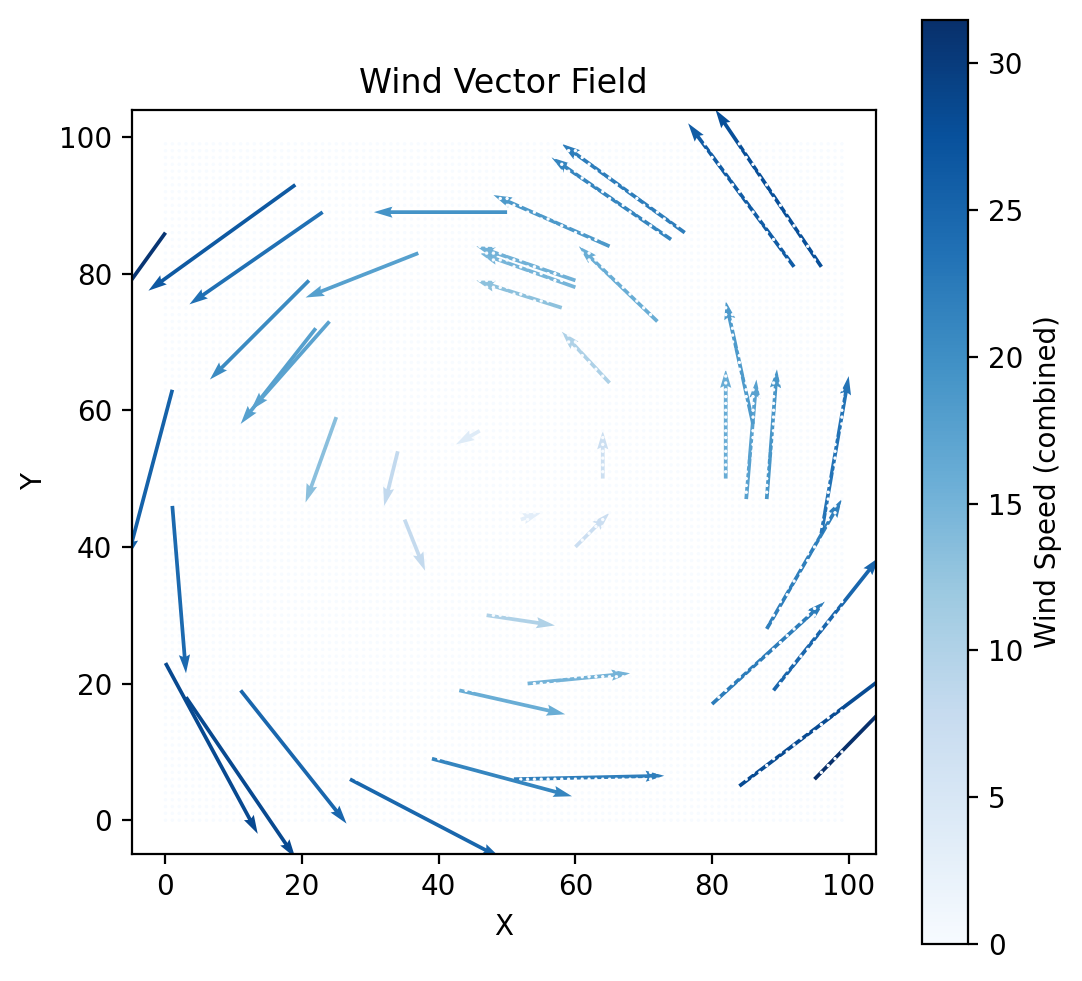

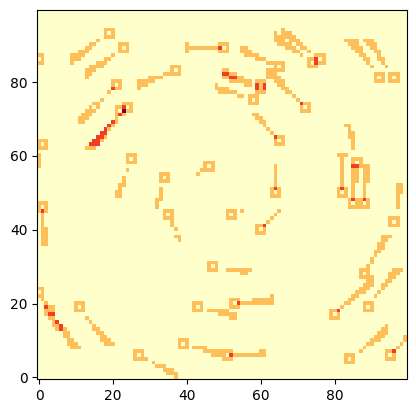

In [793]:
def plot_board_fireExposure(forest):
    img = plt.imshow([[cell.get_FireExposure() for cell in row] for row in forest], origin="lower", cmap="YlOrRd")
    return img

plot_board_wind(forest)
fire_exposure_map = plot_board_fireExposure(forest)

# Rain

In [794]:
def constant_rain(forest, row, col, size=(10, 10), strength=1):
    '''
    Set up a rain cloud at a cell or multiple (depending on size) at (row, col)
    '''
    for x_offset in range(size[0]):
        for y_offset in range(size[1]):
            current_moisture = forest[row+x_offset, col+y_offset].get_Moisture()
            #  Set moisture (max 100% concentration)
            forest[row+x_offset, col+y_offset].set_Moisture(min(current_moisture + strength, 100))
    return forest

# Visualizing moisture

In [795]:
def plot_board_moisture(forest, ax=None):
    n_rows, n_cols = forest.shape

    # Build the moisture grid
    grid = np.zeros((n_rows, n_cols))
    for i in range(n_rows):
        for j in range(n_cols):
            grid[i, j] = forest[i][j].get_Moisture()

    # Create coordinate grid
    y, x = np.meshgrid(np.arange(n_rows), np.arange(n_cols), indexing='ij')

    # Flatten everything for scatter
    x_flat = x.flatten()
    # print(len(x_flat))
    y_flat = y.flatten()
    moisture_flat = grid.flatten()

    # --- Fixed range for marker sizes ---
    size_min = 0    # smallest square
    size_max = 1.5   # biggest square

    # Map moisture (0–100) → size range
    sizes = size_min + (moisture_flat / 100.0) * (size_max - size_min)

    if ax==None:
        fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
    sc = ax.scatter(
        x_flat,
        y_flat,
        s=sizes,
        c=moisture_flat,
        cmap="PuBu",
        marker='s',
        vmin=0,
        vmax=100,
        alpha=0.3
    )

    cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.1)
    cbar.set_label("Moisture %")

    ax.set_aspect('equal')
    # ax.set_title("Moisture Concentration")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    
    return ax


<Axes: xlabel='X', ylabel='Y'>

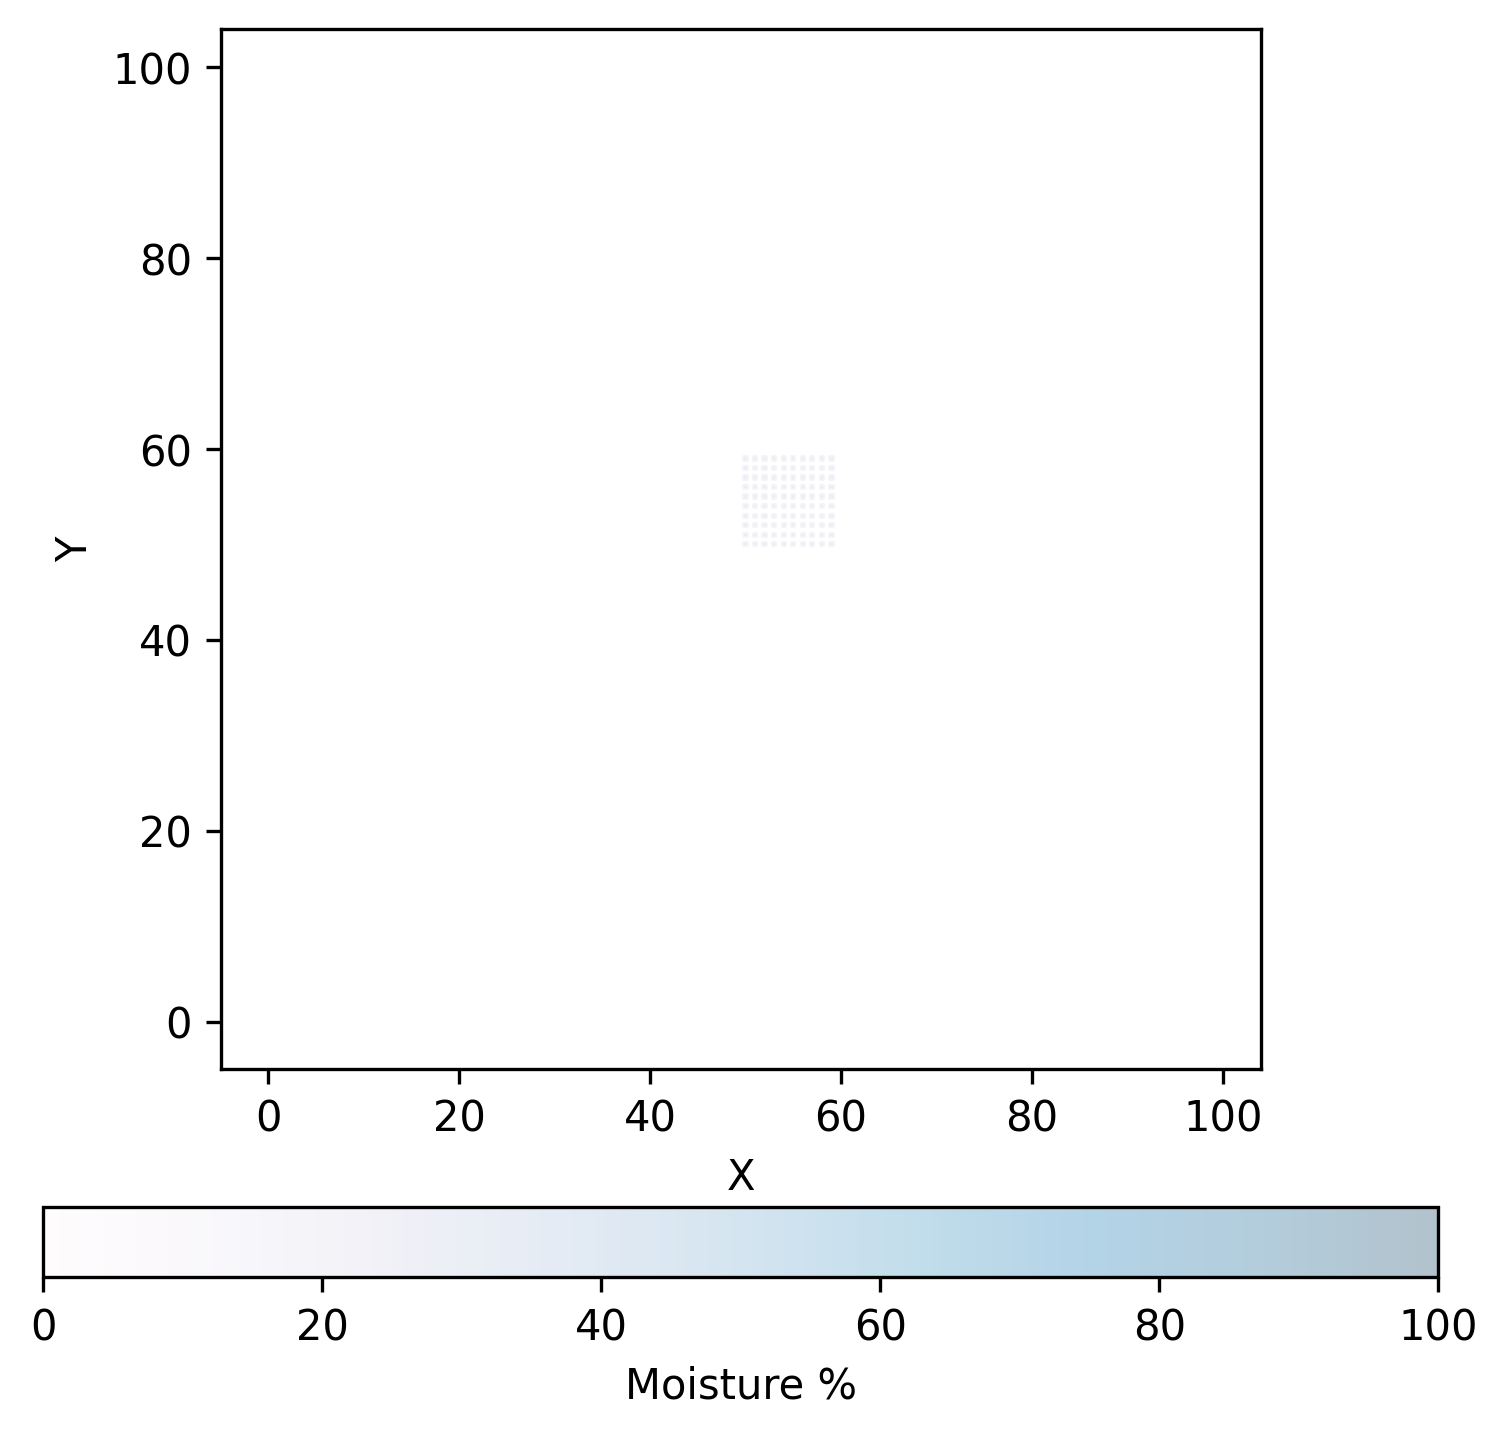

In [796]:
constant_rain(forest, 50, 50, strength=20)
plot_board_moisture(forest)

# Step algorithms

<u>Algorithm:</u>

The motivation for the model is that fire spreads to neighbouring areas. After trees have burnt they take
some time to regrow and become flammable again.

For an arbitrary state, one update of the system consists of the following steps, performed in parallel for all
cells:

1. Spread fire: a flammable cell with at least one burning neighbour becomes burning (otherwise it
remains flammable).
2. Burning: a burning cell becomes burnt.
3. Germination: a burnt cell becomes growing.
4. Grow: a growing cell becomes flammable.

In [797]:
# green (0) = flammable, gold (1) = growing, dark_gray (2) = burnt, dark_orange (3) = burning

def step(forest, growth_delay=0):
    next_forest = new_forest(forest.shape)

    for row in range(forest.shape[0]):
        for col in range(forest.shape[1]):

            cell = get_cell(forest, row, col) # old cell
            state = cell.get_State()
            next_cell = get_cell(next_forest, row, col) # new cell

            if state == 3: # burning -> burnt
                next_cell.set_State(2)
            elif state == 2: # burnt -> start growing
                next_cell.set_State(1)
            elif state == 1: # growing
                if cell.get_GrowthCounter() == growth_delay: # done growing -> flammable
                    next_cell.set_State(0)
                    next_cell.reset_GrowthCounter()
                else:
                    # still growing, increment counter
                    next_cell.set_State(1)
                    next_cell.set_GrowthCounter(cell.get_GrowthCounter() + 1)
            elif state == 0: # flammable
                num_neighbours = count_neighbours(forest, row, col)
                if num_neighbours[3] > 0:
                    next_cell.set_State(3) # burning
                else:
                    next_cell.set_State(0)

    return next_forest


In [798]:
import copy

def step_wind(forest, wind, wind_parameters, fire_exposure_radius, rain, rain_parameters, revive_delay=0, growth_delay=0):
    # Deep copy the entire forest grid (so each Cell is copird with its attributes)
    next_forest = copy.deepcopy(forest)

    wind(next_forest, *wind_parameters) # apply wind to next step
    rain(next_forest, *rain_parameters) # apply rain to next step

    for row in range(forest.shape[0]):
        for col in range(forest.shape[1]):

            cell = forest[row, col] # old cell (time t)
            next_cell = next_forest[row, col] # corresponding new cell (time t+1)

            fire_exposure(forest, row, col, fire_exposure_radius) # calculate fire exposure at time t
            state = cell.get_State()

            if cell.get_VegType() == "Clear": # cell is clear or empty
                next_cell.set_State(state)
            else:
                if state == 3: # burning -> burnt
                    next_cell.set_State(2)
                elif state == 2: # burnt -> start growing
                    if cell.get_ReviveCounter() == revive_delay:
                        next_cell.set_State(1)
                        next_cell.reset_ReviveCounter()
                    else:
                        next_cell.set_State(2)
                        next_cell.set_ReviveCounter(cell.get_ReviveCounter() + 1)
                elif state == 1: # growing
                    if cell.get_GrowthCounter() == growth_delay:
                        next_cell.set_State(0) # now flammable
                        next_cell.reset_GrowthCounter()
                    else:
                        next_cell.set_State(1)
                        next_cell.set_GrowthCounter(cell.get_GrowthCounter() + 1)
                elif state == 0: # flammable
                    # exposure = cell.get_FireExposure()
                    # num_neighbours = count_neighbours(forest, row, col)
                    cell.calc_ProbBurn()
                    prob = cell.get_ProbBurn()
                    set_fire = np.random.rand(1) < prob
                    if set_fire:
                        next_cell.set_State(3) # burning
                    else:
                        next_cell.set_State(0)

    return next_forest


# Tests

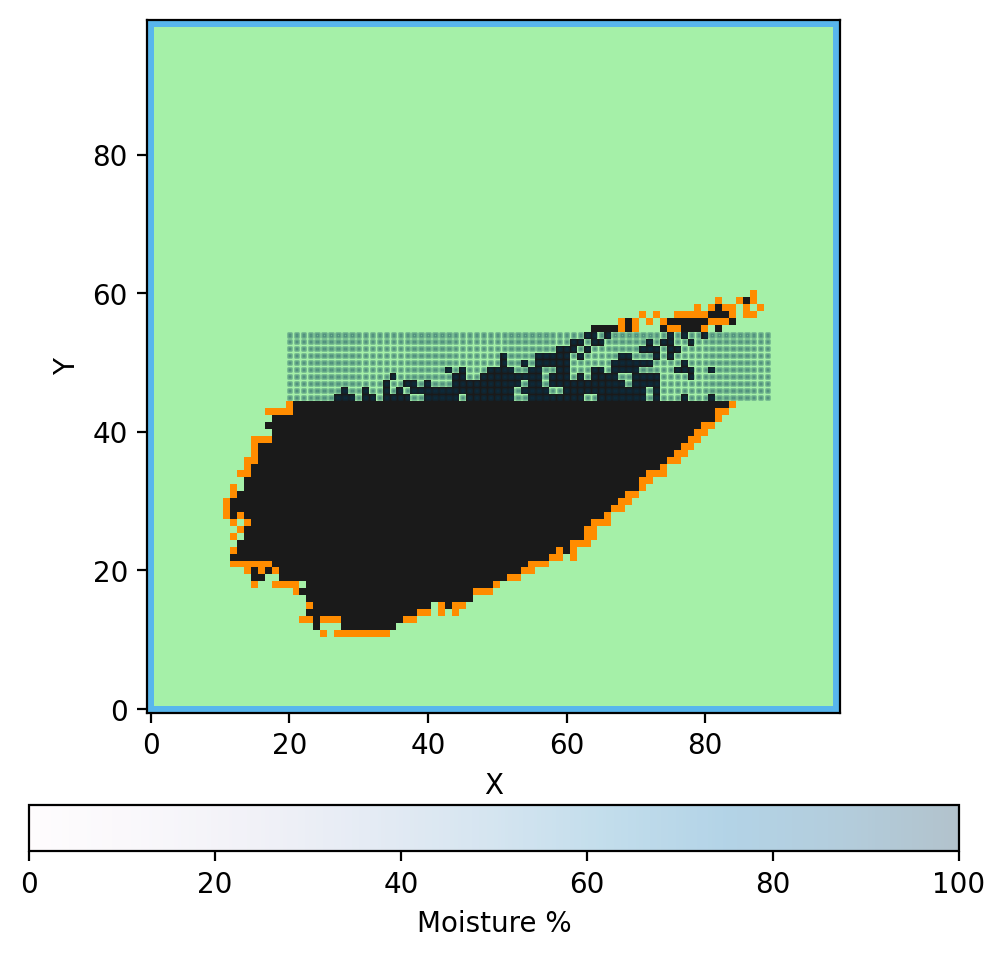

In [799]:
# set an initial board
# set a number of steps
# set up a figure
# do the animation
import matplotlib.animation as animation

# board = random_forest_fire([100, 100], 0.003)
board = localized_forest_fire([100,100], 30, 30, (2,2))

constant_wind(board, 5, 2)
# vortex_wind(board, 25, 25, 2)

# fig, ax = plt.subplots()
img = plot_board(board)
# display(fig)
plt.pause(0.2)
clear_output(wait=True)

n_steps = 20

for i_step in range(n_steps):
    board = step_wind(board, constant_wind, [5, 2], 5, constant_rain, [45, 20, (10, 70), 5], 20, 15)
    
    img = plot_board(board)
    img = plot_board_moisture(board, img)
    plt.pause(0.05)
    clear_output(wait=True)
    # display(fig)

# Importing real map

In [800]:
import numpy as np
import rasterio as rio
from rasterio.plot import show, show_hist
import os
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.mask import mask
import matplotlib.colors as mcolors
from pathlib import Path

In [801]:
ROOT = Path.cwd()   # Folder of this file

dem_path = ROOT / "NVIS7_0_AUST_EXT_MVG_ALB.tif"

with rio.open(dem_path) as src:
    band = src.read(1)
    print(band)

output_path = ROOT / "Output"
output_path.mkdir(exist_ok=True)

gdf_path = ROOT / "LGA_Boundaries_LGATE_233.shp"
gdf = gpd.read_file(gdf_path)

gdf_fremantle = gdf[gdf["name"] == "FREMANTLE, CITY OF"]
gdf_perth = gdf[gdf["name"] == "PERTH, CITY OF"]
gdf_kalamunda = gdf[gdf["name"] == "KALAMUNDA, CITY OF"]

clipped_path = output_path / "clipped.tif"


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [802]:
with rio.open(dem_path) as src:
    if gdf_kalamunda.crs != src.crs:
        gdf_kalamunda = gdf_kalamunda.to_crs(src.crs)

    shapes = gdf_kalamunda.geometry.values
    # print(shapes)
    clipped_image, clipped_image_transform = mask(src, shapes, crop = True)

    meta = src.meta.copy()
    meta.update({
        'height' : clipped_image.shape[1],
        'width' : clipped_image.shape[2],
        'transform' : clipped_image_transform
    })

    with rio.open(clipped_path, "w", **meta) as dst:
        dst.write(clipped_image)

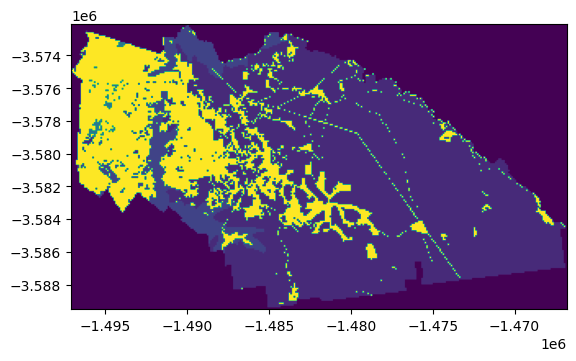

In [803]:
with rio.open(clipped_path) as src:
    show(src)

In [804]:
unique_values = np.unique(clipped_image)
print(unique_values)
print("Number of classes:", len(unique_values))

[ 0  3  5 10 25]
Number of classes: 5


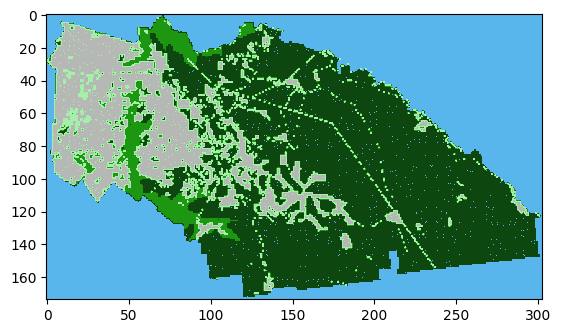

In [805]:
classes = np.array(unique_values)

custom_colours = [
    '#58b6ed', # 0 -- Not in the area
    '#0d470f', # 3 -- Eucalypt Open Forests
    '#1d9612', # 5 -- Eucalypt Woodlands
    '#a5f0a8', # 10 -- Other Forest and Woodland
    '#b6b8b6', # 25 -- Cleared, non-native vegetation, buildings
]
cmap = mcolors.ListedColormap(custom_colours)

boundaries = np.append(classes, classes[-1] + 1)
norm = mcolors.BoundaryNorm(boundaries, cmap.N)

plt.imshow(clipped_image[0], cmap = cmap, norm = norm)

In [806]:
print(type(clipped_image[0]))

<class 'numpy.ndarray'>


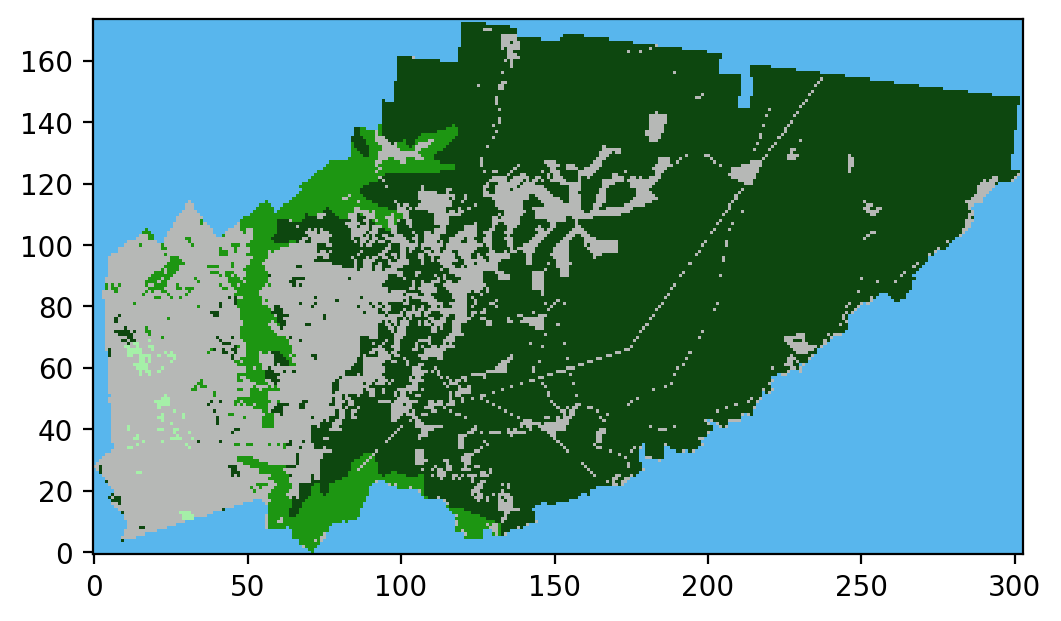

In [807]:
imported_forest = import_forest(clipped_image[0])
img = plot_board(imported_forest)

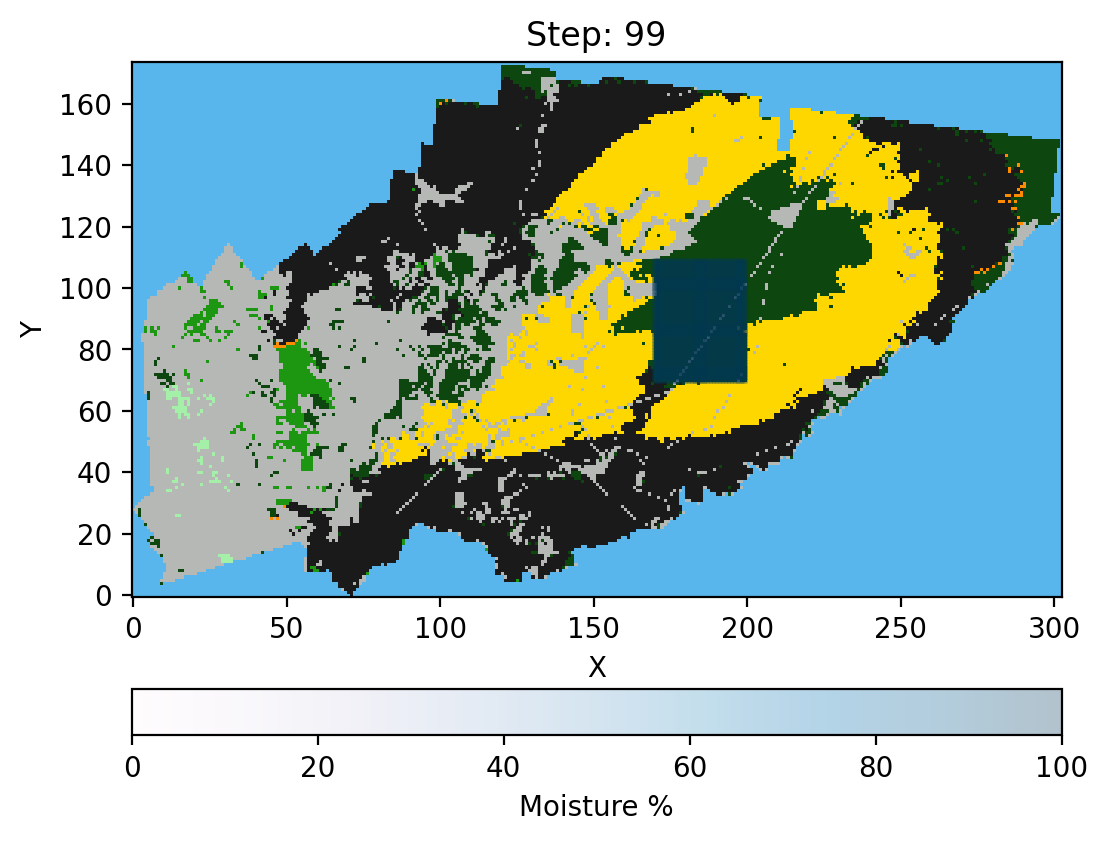

In [809]:
# board = random_forest_fire_import(clipped_image[0], 0.005)
board = localized_forest_fire_import(clipped_image[0], 120, 225, (2,2))

constant_wind(board, -5, -2)
# vortex_wind(board, 100, 100)
img = plot_board(board)
# display(fig)
plt.pause(0.2)
clear_output(wait=True)

n_steps = 100

for i_step in range(n_steps):
    board = step_wind(board, constant_wind, [-5, -2], 5, constant_rain, [70, 170, (40, 30), 3], 40, 30)
    # board = step_wind(board, vortex_wind, [100, 100], 5, 50)
    
    img = plot_board(board)
    img = plot_board_moisture(board, img)
    img.set_title(f"Step: {i_step}")
    plt.pause(0.05)
    clear_output(wait=True)
    # display(fig)

# Metrics of fire impact